In [1]:
import datetime
from pathlib import Path

import geopy.distance
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from tqdm.notebook import tqdm

matplotlib.rcParams.update({'font.size': 15})

import pandas as pd
import seaborn as sns

from utils.transformations.features_extractor import STFTFeaturesExtractor
from utils.data_reading.catalogs.twin_catalog import TwinCatalog
from utils.data_reading.sound_data.station import StationsCatalog
from utils.physics.sound.sound_velocity_grid import MonthlySoundVelocityGridOptimized

In [2]:
# input files
isc_dir = f"/home/plerolland/Bureau/catalogs/ISC"
catalog_path = "/media/plerolland/LaBoite/twin_catalog"
datasets_yaml = "/home/plerolland/Bureau/dataset.yaml"

stations = StationsCatalog(datasets_yaml).filter_out_undated().filter_out_unlocated()
sound_model_g = MonthlySoundVelocityGridOptimized([f"../../../data/sound_model/min-velocities_month-{i:02d}.nc" for i in range(1,13)], interpolate=True)
catalog = TwinCatalog(catalog_path, isc_dir, stations)
IDs = list(catalog.items.keys())

STFT = STFTFeaturesExtractor(None, f_min=0, f_max=240, vmin=60, vmax=140, nperseg=480, overlap=0.75)

res_prefix = "../../../data/T-pick/df"
df = pd.read_pickle(f"{res_prefix}.pkl")

str_c = ["structure", "stations"]
date_c = ["date"]

## Per event analysis

In [80]:
structures = np.array(list(df["structure"]))
structures = set(structures[~(structures == "nan")])
structures.add("other")

params = {}
for ID, row in df.iterrows():
    nb_stations = len(list(row["stations"]))
    params.setdefault("nb_stations", []).append(len(row["stations"]))
    for s in structures:
        params.setdefault(s, []).append(0)
    for k in df.columns:
        if k == "stations":
            continue
        to_add = np.array(row[k]).reshape((-1,))
        
        if k=="structure":
            to_add = [to_add[0] if type(to_add[0]) == np.str_ else "other"]
            params[to_add[0]][-1] = 1
        if "E" in k:
            to_add = np.array([np.log10(a) if a > 0 else np.nan for a in to_add])
            corrected = to_add + np.array([np.log10(d) for d in row["distance_m"]])
            params.setdefault(k+"_corrected", []).append(np.median(corrected) if len(corrected) > 0 else np.nan)
        if len(to_add) == 0 or np.all(to_add == 0) and k in ["mb","MS","Mw"]:
            to_add = [np.nan]
        params.setdefault(k, []).append(np.median(to_add) if k not in str_c+date_c else to_add[0])
params = {k : np.array(p) for k, p in params.items()}

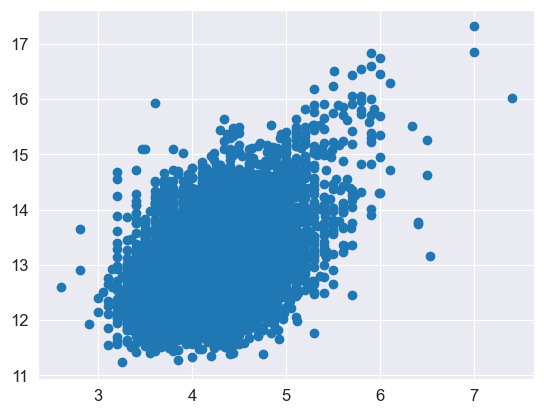

In [83]:
x, y = np.array(params["mb"]), np.array(params["peak_E"])
#x, y = data[0], data[3]

k = ~np.isnan(x) & ~np.isnan(y)
plt.scatter(x[k], y[k])

(27, 7334)


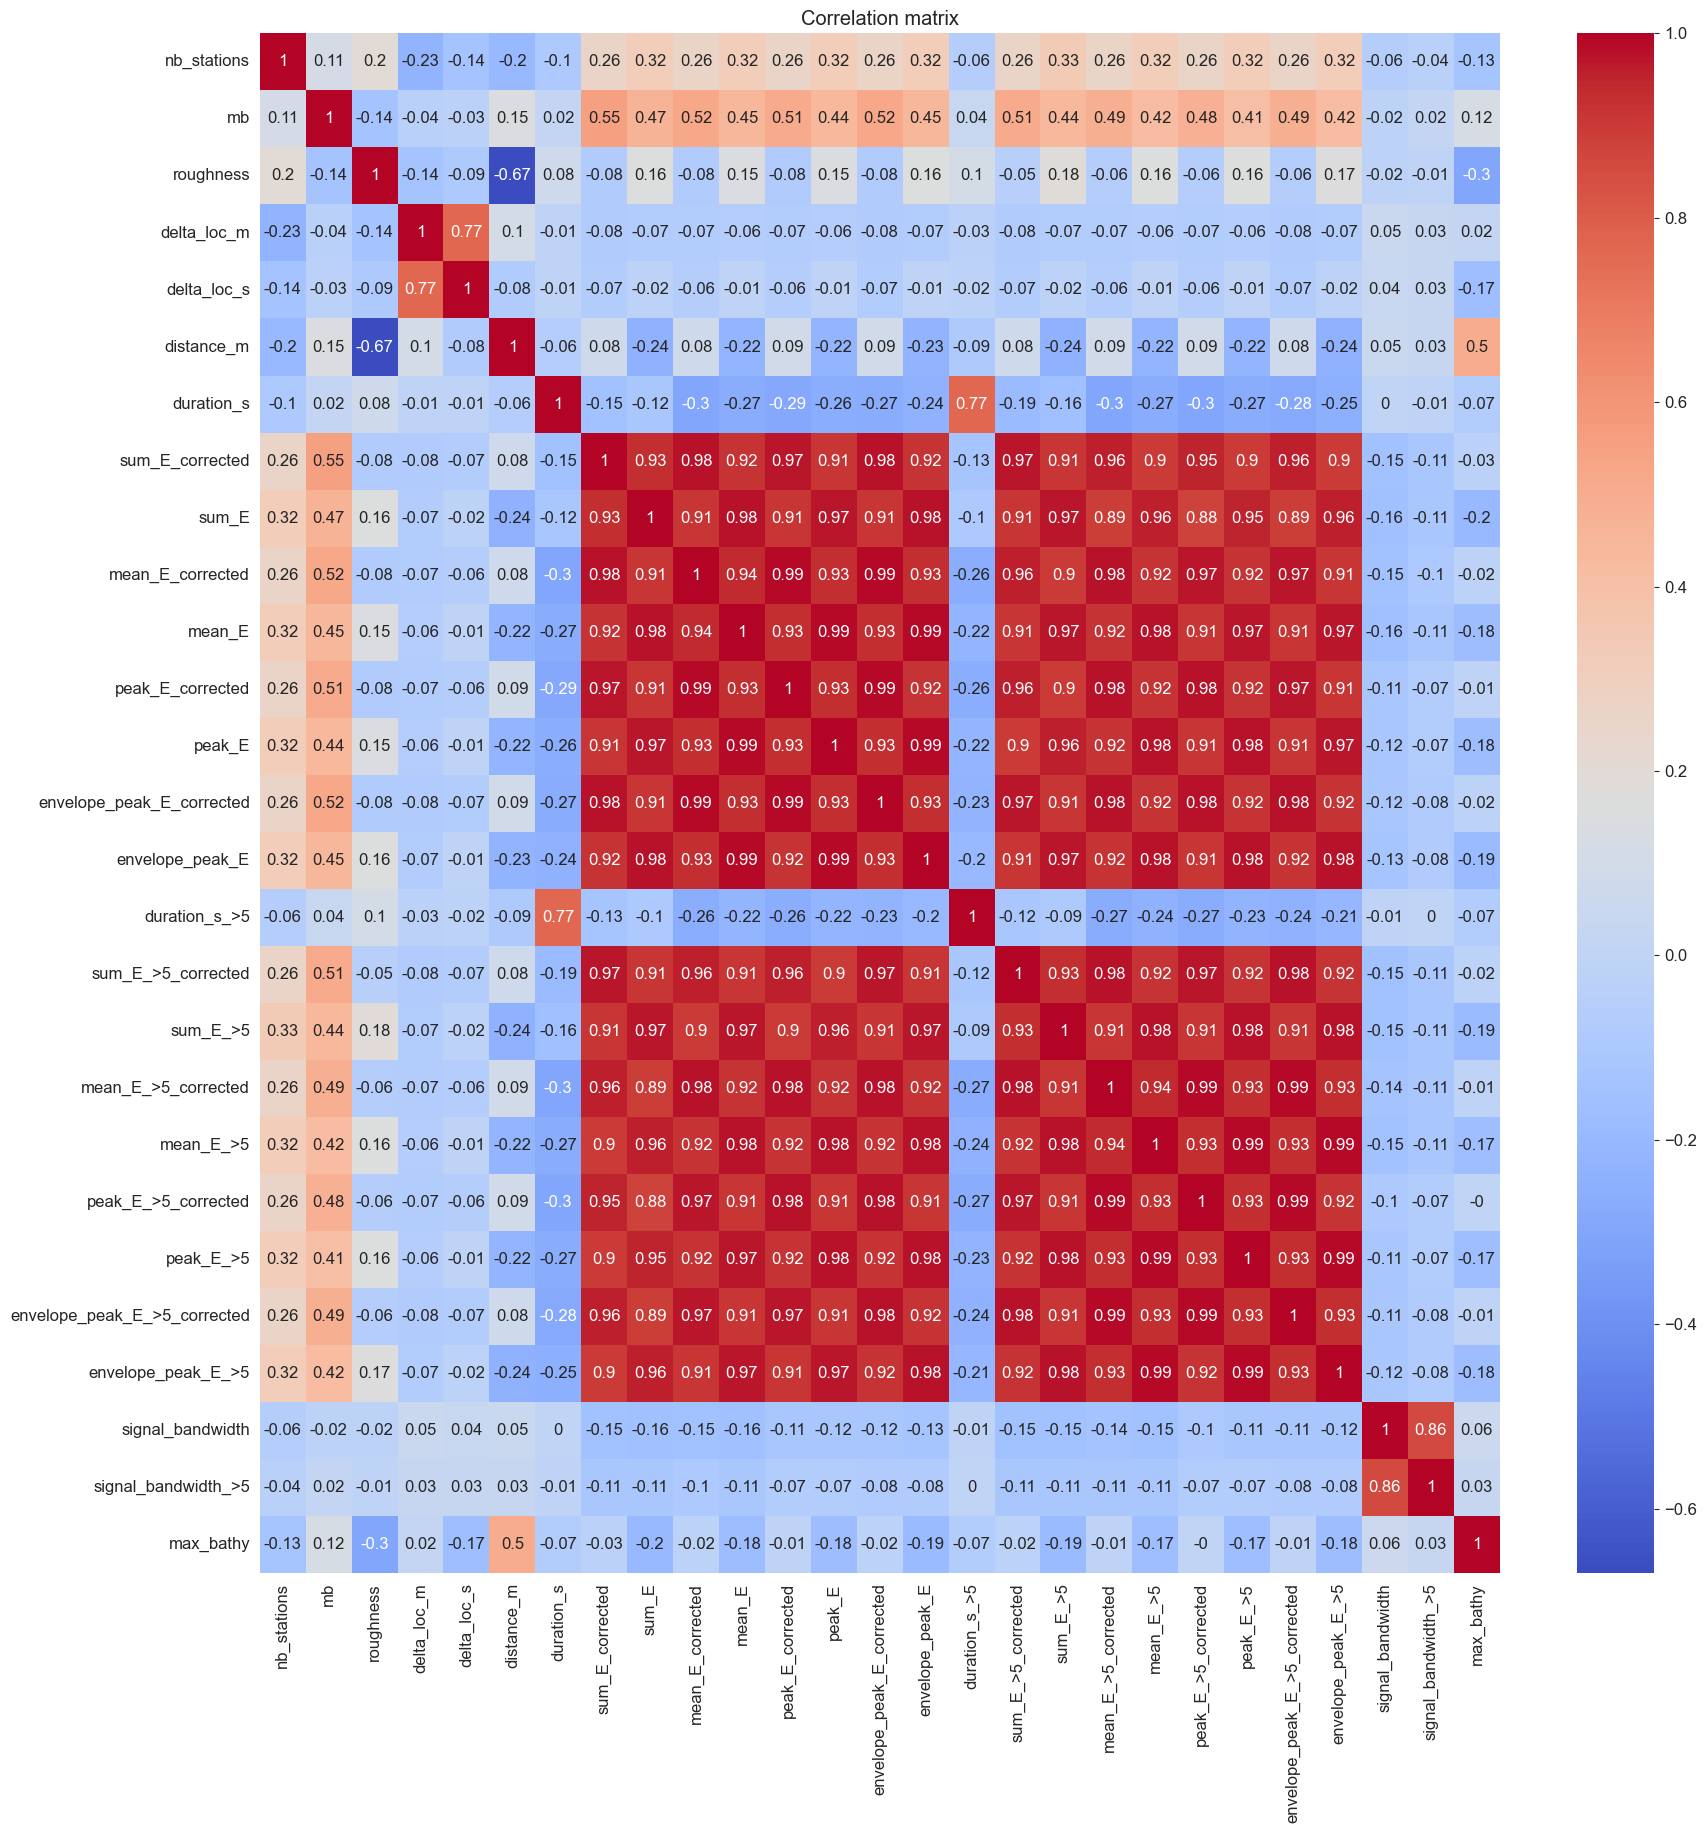

In [84]:
# columns = ['mb', 'Mw', 'MS', 'strike', 'dip', 'rake', 'roughness', 'structure', 'd_from_structure_m', 'azimuth_from_structure', 'd_along_structure_m', 'delta_loc_m', 'delta_loc_s', 'azimuth_loc', 'date', 'lat', 'lon', 'var_loc_s', 'var_loc_lat', 'var_loc_lon', 'stations', 'travel_time_s', 'distance_m', 'azimuth','duration_s','sum_E','mean_E','peak_E','envelope_peak_E','duration_s_>5','sum_E_>5','mean_E_>5','peak_E_>5','envelope_peak_E_>5','signal_bandwidth','signal_bandwidth_>5', 'max_bathy']
not_kept = str_c+date_c
not_kept = ["strike", "dip", "rake", "Mw", "MS", "d_from_structure_m", "d_along_structure_m", "azimuth_from_structure", "lat", "lon", "azimuth", "azimuth_loc", "var_loc_s", "var_loc_lon", "var_loc_lat", "travel_time_s"] + list(structures) + not_kept
kept = [k for k in params if k not in not_kept]
data = np.array([params[k] for k in kept])
kept_idx = np.argwhere(~np.any(np.isnan(data), axis=0))[:,0]
kept_IDs = np.array(IDs)[kept_idx]
data = data[:, kept_idx]
print(data.shape)

corr = np.corrcoef(data)
corr = np.round(corr, 2)

matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, cmap="coolwarm", xticklabels=kept, yticklabels=kept)
plt.title('Correlation matrix')
plt.show()

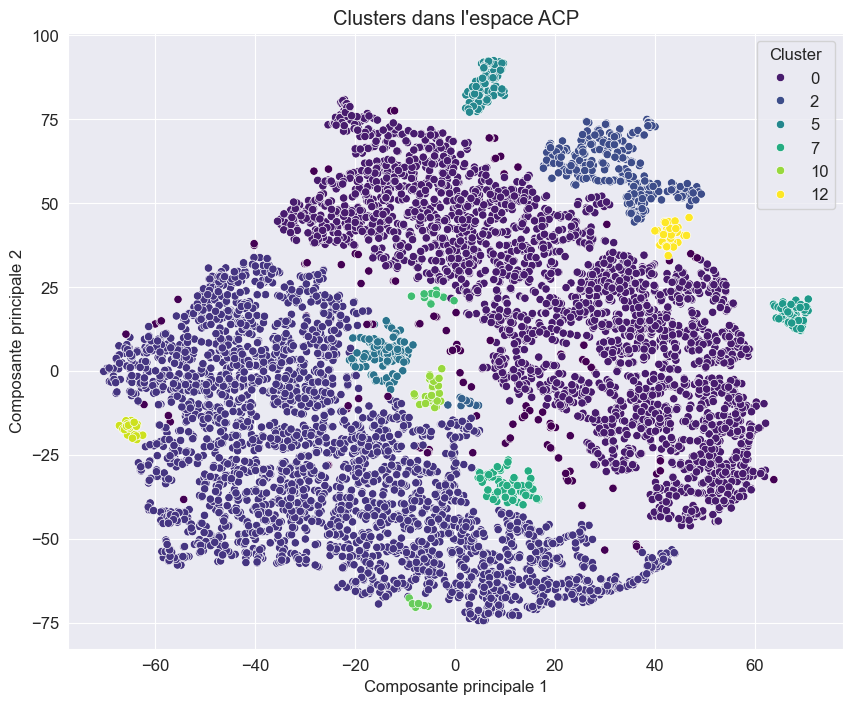

In [77]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler

# Normalisation des données
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data.swapaxes(0,1))

# dimensionality reduction
tsne = TSNE(init='random', perplexity=30)
val = tsne.fit_transform(data_scaled)

# clustering
clusters = DBSCAN(eps=3, min_samples=10).fit_predict(val)

# Visualisation
plt.figure(figsize=(10, 8))
sns.scatterplot(x=val[:, 0], y=val[:, 1], hue=clusters, palette="viridis")
plt.title("Clusters dans l'espace ACP")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.legend(title="Cluster")
plt.show()

In [78]:
out = ""
for i, ID in enumerate(kept_IDs):
    out += f'{df.loc[ID, "lat"]},{df.loc[ID, "lon"]},{(df.loc[ID, "date"]-datetime.datetime(2010,1,1)).total_seconds()},{clusters[i]}\n'
with open("../../../data/T-pick/clusters.csv", "w") as f:
    f.write(out)

## Per peak analysis

In [3]:
params = {}
for ID, row in df.iterrows():
    nb_stations = len(list(row["stations"]))
    if nb_stations == 0:
        continue
    params.setdefault("nb_stations", []).extend([nb_stations] * nb_stations)
    for k in df.columns:
        to_add = np.array(row[k]).reshape((-1,))
        if len(to_add) != 1 and len(to_add) != nb_stations:
            to_add = [np.nan] * nb_stations
        elif to_add[0] == 0 and k in ["mb","MS","Mw"]:
            to_add = [np.nan]
        elif "E" in k:
            to_add = [np.log10(a) if a > 0 else np.nan for a in to_add]
        to_add = np.repeat(to_add, nb_stations) if len(to_add) == 1 else to_add
        params.setdefault(k, []).extend(to_add)

(27, 51704)


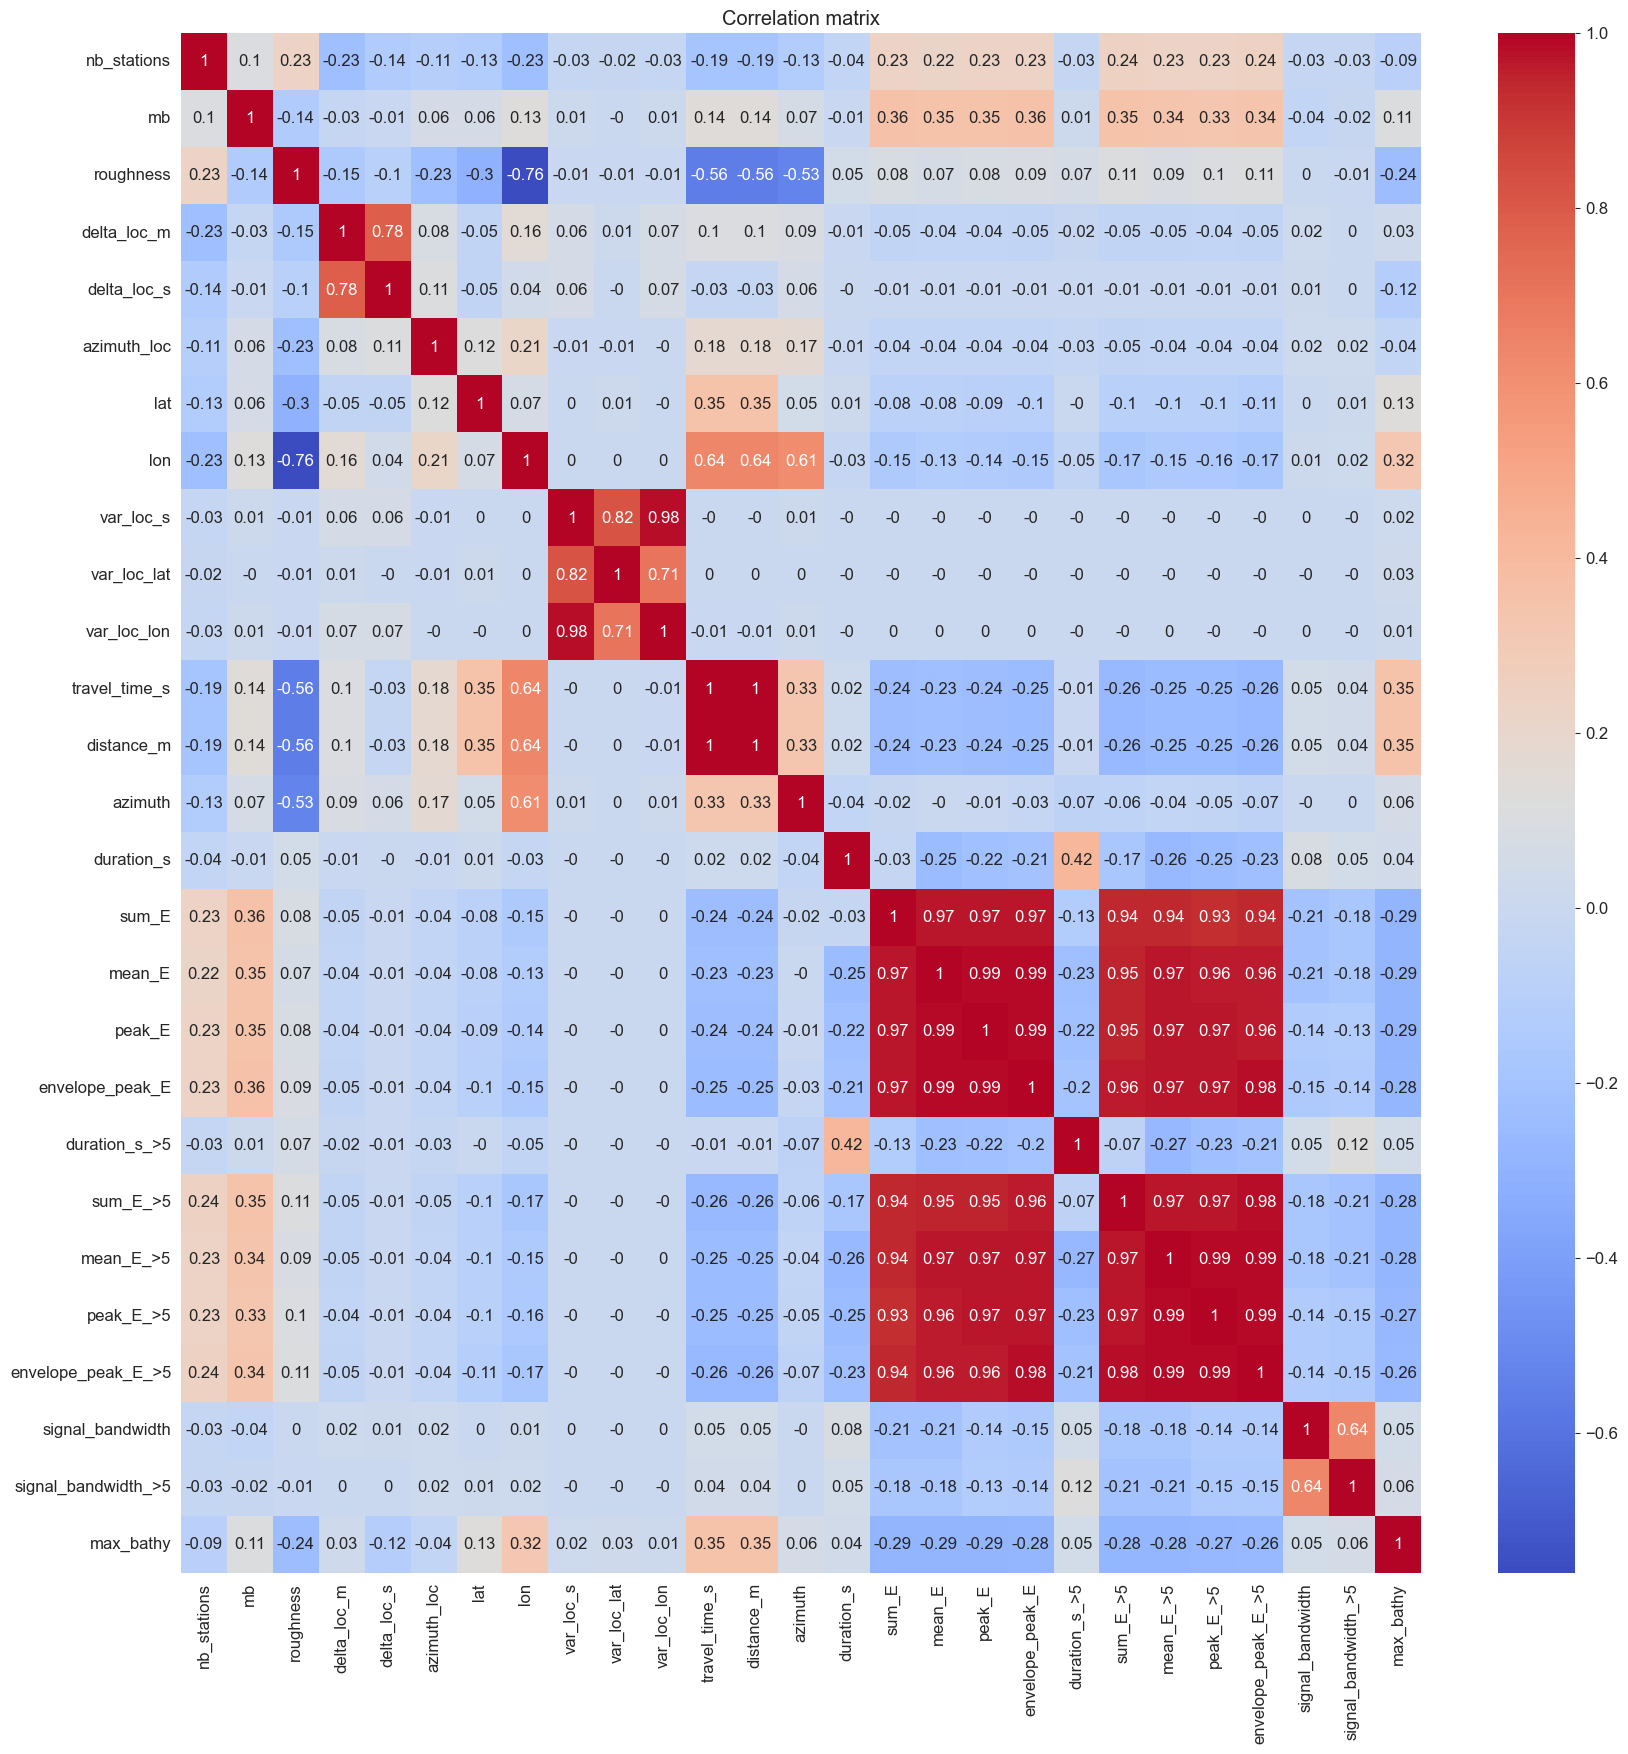

In [150]:
# columns = ['mb', 'Mw', 'MS', 'strike', 'dip', 'rake', 'roughness', 'structure', 'd_from_structure_m', 'azimuth_from_structure', 'd_along_structure_m', 'delta_loc_m', 'delta_loc_s', 'azimuth_loc', 'date', 'lat', 'lon', 'var_loc_s', 'var_loc_lat', 'var_loc_lon', 'stations', 'travel_time_s', 'distance_m', 'azimuth','duration_s','sum_E','mean_E','peak_E','envelope_peak_E','duration_s_>5','sum_E_>5','mean_E_>5','peak_E_>5','envelope_peak_E_>5','signal_bandwidth','signal_bandwidth_>5', 'max_bathy']
not_kept = str_c+date_c
not_kept = ["strike", "dip", "rake", "Mw", "MS", "d_from_structure_m", "d_along_structure_m", "azimuth_from_structure"] + not_kept
kept = [k for k in params if k not in not_kept]


data = np.array([params[k] for k in kept])
data = data[:, ~np.any(np.isnan(data), axis=0)]
print(data.shape)

corr = np.corrcoef(data)
corr = np.round(corr, 2)

matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, cmap="coolwarm", xticklabels=kept, yticklabels=kept)
plt.title('Correlation matrix')
plt.show()

In [12]:
from sklearn.metrics import r2_score
from gplearn.genetic import SymbolicRegressor

kept = ["mb", "roughness", "distance_m", "sum_E"]

data = np.array([params[k] for k in kept])
data = data[:, ~np.any(np.isnan(data), axis=0)]
data = np.swapaxes(data, 0, 1)
data[:,0] = data[:,0]/10
data[:,1] = data[:,1]/500
data[:,2] = np.log10(data[:,2])/10
data[:,3] = data[:,3]/30
print(data.shape)

idx = np.arange(len(data))
np.random.shuffle(idx)
nb_train = int(0.8*len(idx))
X_train = data[idx[:nb_train],1:]
X_test = data[idx[nb_train:],1:]
Y_train = data[idx[:nb_train],0]
Y_test = data[idx[nb_train:],0]

estimator = SymbolicRegressor(population_size=5000, generations=40)

# Entraînement
estimator.fit(X_train, Y_train)

# Prédictions et évaluation
Y_pred = estimator.predict(X_test)
print(f"Score R² : {r2_score(Y_test, Y_pred)}")

# Afficher la formule trouvée
print("Formule trouvée :", estimator._program)

# Score R² : 0.14807413088051835
# Formule trouvée : mul(X1, add(0.121, X2))

(52291, 4)
Score R² : 0.14807413088051835
Formule trouvée : mul(X1, add(0.121, X2))
